In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt
from data import calculate_synthetic_scores, calculate_CIFAR_scores
np.random.seed(0)

W1116 14:36:33.567762 140214221702976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/compat/v2_compat.py:61: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


### Score matrix and labels

To run the experiments, the following input is required:
- A matrix of classification scores `S`, where rows correspond to data points and columns to classes.<br>
There are `k2` classes and `r` data points in each class.<br>
This code assumes that the classifier predicts the class with the lowest score (e.g. according to distances).
- A vector `Y` of the true labels corresponding to the rows of `S`.

Experiments will be performed by extrapolating accuracy from `k1` to `k2` classes. 

Here we provide two examples for `S` and `Y`, based on either synthetic data or the CIFAR-100 dataset (already included in TensorFlow) - see `data.py` for details. Run the relevant notebook cell below:

#### Synthetic data

In [ ]:
k1 = 500
k2 = 2000

y_dist = 'normal'  # distribution of class centroids, possible values are 'normal' or 'uniform'
x_dist = 'normal'  # distribution of data points around class centroids, possible values are 'normal' or 'uniform'
sigma2 = 0.1       # variance of data points

d = 5              # data dimension
r = 10             # number of data points from each class

S, Y = calculate_synthetic_scores(k2, d, r, sigma2, x_dist, y_dist)

#### CIFAR-100

In [2]:
k1 = 10
k2 = 100

S, Y = calculate_CIFAR_scores()

W1116 14:36:42.434901 140214221702976 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### NN architecture

In [3]:
avg_acc_ = tf.placeholder(tf.float32, shape=[k1-1], name='avg_acc')
S_correct_ = tf.placeholder(tf.float32, shape=[None, 1], name='S_correct')
S_incorrect_ = tf.placeholder(tf.float32, shape=[None, k1-1], name='S_incorrect')

In [4]:
W1 = tf.get_variable('W1', shape=[k1, 512], dtype=tf.float32)
b1 = tf.get_variable('b1', shape=[512], dtype=tf.float32)
W2 = tf.get_variable('W2', shape=[512, 128], dtype=tf.float32)
b2 = tf.get_variable('b2', shape=[128], dtype=tf.float32)
W3 = tf.get_variable('W3', shape=[128, 1], dtype=tf.float32)
b3 = tf.get_variable('b3', shape=[1], dtype=tf.float32)

h1 = tf.nn.relu(tf.matmul(tf.concat([S_correct_, S_incorrect_], axis=1), W1) + b1)
h2 = tf.nn.relu(tf.matmul(h1, W2) + b2)
C = tf.nn.sigmoid(tf.matmul(h2, W3) + b3)

In [5]:
ks_tf = tf.constant(np.arange(1, k1), dtype=tf.float32)
est_acc = tf.reduce_mean(tf.math.pow(1 - C, ks_tf), axis=0)

In [6]:
loss = tf.reduce_mean(tf.square(est_acc - avg_acc_))
training_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

W1116 14:40:05.708201 140214221702976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Run CleaneX

In [7]:
def split_S(Y, S, smpl=None):
    """Splits the score matrix `S` to a vector of correct scores and a matrix
    of (sorted) incorrect scores, according to the true labels `Y`.
    Use only classes from the subsample `smpl` (if None, use all classes in `Y`).
    """
    if smpl is None:
        K = Y.max() + 1
        smpl = np.arange(K)

    sub_Y = Y[np.isin(Y, smpl)]
    S_correct = S[np.isin(Y, smpl), sub_Y][:, None]
    S_incorrect = S[np.isin(Y, smpl), :][(np.arange(S.shape[1])[None, :] != sub_Y[:, None]) & \
                                         np.isin(np.arange(S.shape[1]), smpl)].reshape(sub_Y.shape[0], -1)
    S_incorrect.sort(axis=1)
    
    return S_correct, S_incorrect

The average accuracy over all choices of $k \leq K$ classes is given by
\begin{equation}
    \bar{\mathcal{A}}^K_k = \frac{1}{r k} \sum_x \frac{\binom{R_x}{k - 1}}{\binom{K}{k}} \;,
\end{equation}
where $R_x = |\{y \mid S_{y^*}(x) < S_y(x)\}|$ (see Zheng et al. 2018). Note that we are dealing with distances, where a lower score is better, so the inequality in the definition of $R_x$ is inverted with respect to the paper.

Therefore, we have 
\begin{multline}
\bar{\mathcal{A}}^K_k
= \frac{1}{r K} \sum_x \frac{\binom{R_x}{k - 1}}{\frac{k}{K} \binom{K}{k}}
= \frac{1}{r K} \sum_x \frac{\binom{R_x}{k - 1}}{\binom{K - 1}{k - 1}}
= \frac{1}{r K} \sum_x \frac{\prod_{i=1}^{k-1} \frac{R_x + 1 - i}{i}}{\prod_{i=1}^{k-1} \frac{K - i}{i}} \\
= \frac{1}{r K} \sum_x \prod_{i=1}^{k-1} \frac{R_x + 1 - i}{K - i}
= \frac{1}{r K} \sum_x \exp \left( \sum_{i=1}^{k-1} \Big( \log(R_x + 1 - i) - \log(K - i) \Big) \right) \;.
\end{multline}

In [8]:
def calculate_avg_accuracy(Y, S, smpl=None):
    """Given the true labels `Y` and score matrix `S`, calculates the average
    accuracy over all choices of k >= 2 classes.
    Use only classes from the subsample `smpl` (if None, use all classes in `Y`).
    """
    if smpl is None:
        K = Y.max() + 1
        smpl = np.arange(K)
    else:
        K = len(smpl)
    
    sub_Y = Y[np.isin(Y, smpl)]
    R = np.sum(S[np.isin(Y, smpl), sub_Y][:, None] < S[np.isin(Y, smpl), :][:, smpl], axis=1, keepdims=True)
    a = np.log(np.maximum(R + 1 - np.arange(1, K), 1e-16))  # avoid log(0)
    b = np.log(K - np.arange(1, K))
    cum_sum = np.cumsum(a - b, axis=1)
    avg_A = np.mean(np.exp(cum_sum), axis=0)
    
    return avg_A

#### Run experiments

In [9]:
repetitions = 10     # number of experiment repetitions (subsamples of k1 classes)
iterations = 10000   # number of training iterations

In [10]:
sess = tf.Session()

all_est_accs = []
all_avg_accs = []

for rep in range(repetitions):
    print('Repetition no. {}'.format(rep + 1))
    
    # Subsample k1 classes:
    smpl = np.random.choice(k2, k1, replace=False)

    # Calculate average accuracies on chosen k1 classes:
    avg_accuracy = calculate_avg_accuracy(Y, S, smpl)

    # Get scores of correct and incorrect classes:
    S_correct, S_incorrect = split_S(Y, S, smpl)
    
    # Normalize scores:
    full_S = np.hstack([S_correct, S_incorrect])
    S_correct = (S_correct - full_S.mean())/full_S.std()
    S_incorrect = (S_incorrect - full_S.mean())/full_S.std()

    # Train:
    sess.run(tf.global_variables_initializer())
    for i in range(iterations):
        l, _ = sess.run([loss, training_step], feed_dict={S_correct_: S_correct,
                                                          S_incorrect_: S_incorrect,
                                                          avg_acc_: avg_accuracy})
        if ((i + 1) % 100) == 0:
            print('Iteration {}\tMSE loss: {:.8f}'.format(i + 1, l))

    # Predict accuracy for all 2 <= k <= k2:
    C_pred = sess.run(C, feed_dict={S_correct_: S_correct, S_incorrect_: S_incorrect})
    est_acc = np.power(1 - C_pred, np.arange(1, k2)).mean(axis=0)
    
    # Save current experiment results:
    all_avg_accs.append(avg_accuracy)
    all_est_accs.append(est_acc)

sess.close()

Repetition no. 1
Iteration 100	MSE loss: 0.00082878
Iteration 200	MSE loss: 0.00066701
Iteration 300	MSE loss: 0.00063601
Iteration 400	MSE loss: 0.00059905
Iteration 500	MSE loss: 0.00055586
Iteration 600	MSE loss: 0.00050615
Iteration 700	MSE loss: 0.00044933
Iteration 800	MSE loss: 0.00038716
Iteration 900	MSE loss: 0.00032234
Iteration 1000	MSE loss: 0.00025781
Iteration 1100	MSE loss: 0.00018597
Iteration 1200	MSE loss: 0.00011508
Iteration 1300	MSE loss: 0.00005916
Iteration 1400	MSE loss: 0.00001844
Iteration 1500	MSE loss: 0.00000771
Iteration 1600	MSE loss: 0.00000582
Iteration 1700	MSE loss: 0.00000551
Iteration 1800	MSE loss: 0.00000536
Iteration 1900	MSE loss: 0.00000522
Iteration 2000	MSE loss: 0.00000508
Iteration 2100	MSE loss: 0.00000494
Iteration 2200	MSE loss: 0.00000480
Iteration 2300	MSE loss: 0.00000467
Iteration 2400	MSE loss: 0.00000454
Iteration 2500	MSE loss: 0.00000440
Iteration 2600	MSE loss: 0.00000427
Iteration 2700	MSE loss: 0.00000413
Iteration 2800	MSE l

Iteration 2800	MSE loss: 0.00000005
Iteration 2900	MSE loss: 0.00000004
Iteration 3000	MSE loss: 0.00000004
Iteration 3100	MSE loss: 0.00000004
Iteration 3200	MSE loss: 0.00000004
Iteration 3300	MSE loss: 0.00000004
Iteration 3400	MSE loss: 0.00000004
Iteration 3500	MSE loss: 0.00000004
Iteration 3600	MSE loss: 0.00000004
Iteration 3700	MSE loss: 0.00000004
Iteration 3800	MSE loss: 0.00000004
Iteration 3900	MSE loss: 0.00000003
Iteration 4000	MSE loss: 0.00000003
Iteration 4100	MSE loss: 0.00000003
Iteration 4200	MSE loss: 0.00000003
Iteration 4300	MSE loss: 0.00000003
Iteration 4400	MSE loss: 0.00000003
Iteration 4500	MSE loss: 0.00000003
Iteration 4600	MSE loss: 0.00000003
Iteration 4700	MSE loss: 0.00000003
Iteration 4800	MSE loss: 0.00000003
Iteration 4900	MSE loss: 0.00000003
Iteration 5000	MSE loss: 0.00000003
Iteration 5100	MSE loss: 0.00000003
Iteration 5200	MSE loss: 0.00000003
Iteration 5300	MSE loss: 0.00000003
Iteration 5400	MSE loss: 0.00000003
Iteration 5500	MSE loss: 0.0

Iteration 5600	MSE loss: 0.00000064
Iteration 5700	MSE loss: 0.00000063
Iteration 5800	MSE loss: 0.00000062
Iteration 5900	MSE loss: 0.00000061
Iteration 6000	MSE loss: 0.00000059
Iteration 6100	MSE loss: 0.00000058
Iteration 6200	MSE loss: 0.00000057
Iteration 6300	MSE loss: 0.00000056
Iteration 6400	MSE loss: 0.00000054
Iteration 6500	MSE loss: 0.00000053
Iteration 6600	MSE loss: 0.00000052
Iteration 6700	MSE loss: 0.00000050
Iteration 6800	MSE loss: 0.00000049
Iteration 6900	MSE loss: 0.00000048
Iteration 7000	MSE loss: 0.00000047
Iteration 7100	MSE loss: 0.00000045
Iteration 7200	MSE loss: 0.00000044
Iteration 7300	MSE loss: 0.00000044
Iteration 7400	MSE loss: 0.00000042
Iteration 7500	MSE loss: 0.00000041
Iteration 7600	MSE loss: 0.00000040
Iteration 7700	MSE loss: 0.00000038
Iteration 7800	MSE loss: 0.00000037
Iteration 7900	MSE loss: 0.00000036
Iteration 8000	MSE loss: 0.00000035
Iteration 8100	MSE loss: 0.00000034
Iteration 8200	MSE loss: 0.00000033
Iteration 8300	MSE loss: 0.0

Iteration 8400	MSE loss: 0.00000002
Iteration 8500	MSE loss: 0.00000001
Iteration 8600	MSE loss: 0.00000001
Iteration 8700	MSE loss: 0.00000001
Iteration 8800	MSE loss: 0.00000001
Iteration 8900	MSE loss: 0.00000002
Iteration 9000	MSE loss: 0.00000001
Iteration 9100	MSE loss: 0.00000001
Iteration 9200	MSE loss: 0.00000001
Iteration 9300	MSE loss: 0.00000002
Iteration 9400	MSE loss: 0.00000001
Iteration 9500	MSE loss: 0.00000001
Iteration 9600	MSE loss: 0.00000001
Iteration 9700	MSE loss: 0.00000003
Iteration 9800	MSE loss: 0.00000001
Iteration 9900	MSE loss: 0.00000001
Iteration 10000	MSE loss: 0.00000001
Repetition no. 8
Iteration 100	MSE loss: 0.00102367
Iteration 200	MSE loss: 0.00099691
Iteration 300	MSE loss: 0.00095964
Iteration 400	MSE loss: 0.00089397
Iteration 500	MSE loss: 0.00079366
Iteration 600	MSE loss: 0.00066794
Iteration 700	MSE loss: 0.00051949
Iteration 800	MSE loss: 0.00037400
Iteration 900	MSE loss: 0.00024607
Iteration 1000	MSE loss: 0.00014230
Iteration 1100	MSE 

Iteration 1100	MSE loss: 0.00014038
Iteration 1200	MSE loss: 0.00006436
Iteration 1300	MSE loss: 0.00002390
Iteration 1400	MSE loss: 0.00000877
Iteration 1500	MSE loss: 0.00000380
Iteration 1600	MSE loss: 0.00000321
Iteration 1700	MSE loss: 0.00000315
Iteration 1800	MSE loss: 0.00000310
Iteration 1900	MSE loss: 0.00000304
Iteration 2000	MSE loss: 0.00000298
Iteration 2100	MSE loss: 0.00000292
Iteration 2200	MSE loss: 0.00000285
Iteration 2300	MSE loss: 0.00000277
Iteration 2400	MSE loss: 0.00000268
Iteration 2500	MSE loss: 0.00000257
Iteration 2600	MSE loss: 0.00000246
Iteration 2700	MSE loss: 0.00000235
Iteration 2800	MSE loss: 0.00000223
Iteration 2900	MSE loss: 0.00000211
Iteration 3000	MSE loss: 0.00000198
Iteration 3100	MSE loss: 0.00000186
Iteration 3200	MSE loss: 0.00000174
Iteration 3300	MSE loss: 0.00000162
Iteration 3400	MSE loss: 0.00000150
Iteration 3500	MSE loss: 0.00000139
Iteration 3600	MSE loss: 0.00000129
Iteration 3700	MSE loss: 0.00000119
Iteration 3800	MSE loss: 0.0

### Plot results

In [11]:
avg_acc = calculate_avg_accuracy(Y, S)  # calculate average accuracy for 2 <= k <= k2

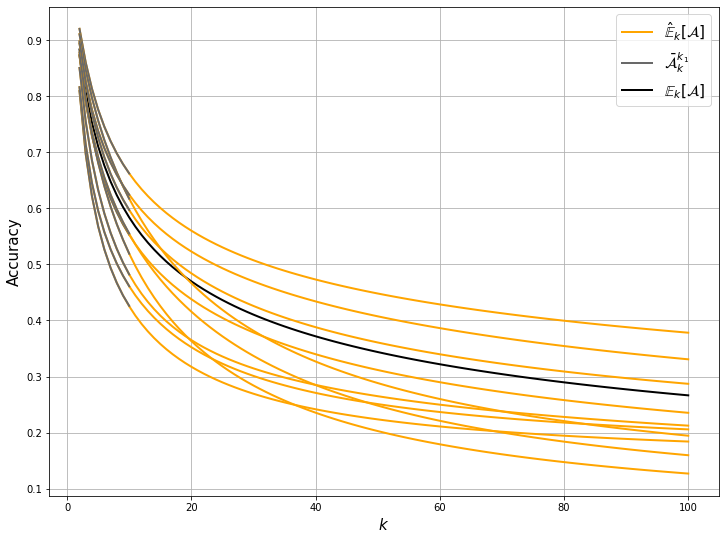

In [12]:
ks_k2 = np.arange(2, k2 + 1)
ks_k1 = np.arange(2, k1 + 1)

plt.figure(figsize=(12, 9))

# Plot the average accuracy for 2 <= k <= k2:
exp_k2_plt, = plt.plot(ks_k2, avg_acc, color='k', linewidth=2)

for rep in range(repetitions):
    # Plot the estimated average accuracy for 2 <= k <= k2:
    est_plt, = plt.plot(ks_k2, all_est_accs[rep], color='orange',  linewidth=2)
    # Plot the average accuracies over the experiment's subsample of k1 classes:
    exp_plt, = plt.plot(ks_k1, all_avg_accs[rep], color='dimgrey', linewidth=2)
        
plt.grid()
plt.xlabel(r'$k$', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend([est_plt, exp_plt, exp_k2_plt], [r'$\hat{\mathbb{E}}_{k}[{\mathcal{A}}]$',
                                            r'$\bar{\mathcal{A}}^{k_1}_k$',
                                            r'$\mathbb{E}_k[{\mathcal{A}}]$'], fontsize = 15);